# Initialize

In [1]:
# Authors: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
#          Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Nicolas P. Rougier (graph code borrowed from his matplotlib gallery)
#
# License: BSD (3-clause)

import numpy as np
import os.path as op
import os
import matplotlib.pyplot as plt
from langouEEG import *
from scipy.stats import *

import mne
import pickle
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle
import mne
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.minimum_norm import write_inverse_operator

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import mne

sample_data_folder = mne.datasets.sample.data_path()
dataRoot = "/data/home/viscent/Light"
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
isMale = False
isAll = True
isBlind = True
if not isAll:
    result_dir = op.join(dataRoot,'result','male' if isMale else 'female')
else:
    result_dir = op.join(dataRoot,'result','all')
if isBlind:
    result_dir = op.join(result_dir,'Blind')
subjects_dir = op.dirname(fs_dir)
if not op.exists(result_dir):
    os.mkdir(result_dir)
# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
print(__doc__)

0 files missing from root.txt in /data/home/viscent/freesurfer/subjects
0 files missing from bem.txt in /data/home/viscent/freesurfer/subjects/fsaverage
Automatically created module for IPython interactive environment


# Load data

In [2]:
epochs_4F = dict()
epochs_RF = dict()
epochs_4R = dict()
epochs_RR = dict()
for subject_name in range(21,24):
    if not isAll:
        if not (isMale ^ (subject_name in [7,8,11,17])):
            continue
    if subject_name<10:
        subject_name='S0'+str(subject_name)
    else:
        subject_name='S'+str(subject_name)
    with open(dataRoot+'/clean_data_av/'+subject_name+'_clean.lgeeg','rb') as f:
        raw=pickle.load(f)
    events, event_dict=extractEvents(raw)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=True,
                        exclude='bads')
    if isBlind:
        epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochsBlind(raw,events,picks)
    else:
        epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs(raw,events,picks)
    epochs_4F[subject_name]=epoch_4F
    epochs_RF[subject_name]=epoch_RF
    epochs_RR[subject_name]=epoch_RR
    epochs_4R[subject_name]=epoch_4R
    if not op.exists(os.path.join(dataRoot,'fwd_solution.lgeeg')):
        fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                        bem=bem, eeg=True, mindist=5.0, n_jobs=1)
        print(fwd)
        mne.write_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'),fwd,overwrite=True)
    else:
        fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))
    data_path = sample.data_path()

    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=True,
                        exclude='bads')


 




file info:
<Info | 11 non-empty values
 bads: 1 items (Trigger)
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG, 1 EOG, 1 STIM
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.1 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-08-07 11:56:28 UTC
 nchan: 66
 projs: Average EEG reference: on
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>
channel names:
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'Trigger']
time period:
1599700
events:
Used Annotations descriptions: ['11', '13', '14', '4', '5', '6', '7', '8', '9']
{'11': 1, '13': 2, '14': 3, '4': 4, '5': 5,

# Source Estimation


In [3]:
cons_40 = []
cons_rand = []
act_40 = []
act_40_paired = []
act_rand = []
act_rand_paired = []
for subject_name,_ in epochs_4F.items():
    # Compute inverse solution and for each epoch. By using "return_generator=True"
    # stcs will be a generator object instead of a list.
    epoch_4F = epochs_4F[subject_name]
    epoch_RF = epochs_RF[subject_name]
    result_dir = op.join(dataRoot,'result','male' if isMale else 'female',subject_name)
    fname_stc_4F = op.join(result_dir,subject_name+'_stc_4F.lgeeg')
    fname_stc_RF = op.join(result_dir,subject_name+'_stc_RF.lgeeg')
    fname_tl_4F = op.join(result_dir,subject_name+'_tl_4F.lgeeg')
    fname_tl_RF = op.join(result_dir,subject_name+'_tl_RF.lgeeg')
    fname_inv = os.path.join(dataRoot,'inv_operators',subject_name+'_inv.lgeeg')
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)



    fname_inv_r = os.path.join(dataRoot,'inv_operators',subject_name+'_r_inv.lgeeg')
    fname_cov_r = os.path.join(dataRoot,'noise_covariance',subject_name+'_r_cov.lgeeg')
    fname_inv_4 = os.path.join(dataRoot,'inv_operators',subject_name+'_4_inv.lgeeg')
    fname_cov_4 = os.path.join(dataRoot,'noise_covariance',subject_name+'_4_cov.lgeeg')



    if not os.path.exists(fname_cov_4):  
        noise_cov = mne.compute_covariance(
            epochs_4R[subject_name], tmax=80., method=['shrunk', 'empirical'], rank=None, verbose=True)
        mne.write_cov(fname_cov_4,noise_cov)
    else:   
    # Load data
        noise_cov = mne.read_cov(fname_cov_4)
    
    if not os.path.exists(fname_inv_4):  
        inverse_operator = make_inverse_operator(
            raw.info, fwd, noise_cov, loose=0.2, depth=0.8)
        write_inverse_operator(fname_inv_4,inverse_operator)
    inverse_operator = read_inverse_operator(fname_inv_4)



    snr = 1.0  # use lower SNR for single epochs
    lambda2 = 1.0 / snr ** 2
    method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)
    # Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
    labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                        subjects_dir=subjects_dir)[:68]
    label_colors = [label.color for label in labels]
    # Average the source estimates within each label using sign-flips to reduce
    # signal cancellations, also here we return a generator
    src = inverse_operator['src']
    if op.exists(fname_tl_4F):
        with open(fname_tl_4F,'rb') as f:
            label_ts = pickle.load(f)
    else:
        stcs = apply_inverse_epochs(epoch_4F, inverse_operator, lambda2, method,
                                    pick_ori="normal", return_generator=False)
        label_ts = mne.extract_label_time_course(
            stcs, labels,  src,allow_empty=False, mode='mean_flip', return_generator=False)
        with open(fname_tl_4F,'wb') as f:
            pickle.dump(label_ts,f)
    fmin = 8.
    fmax = 13.
    sfreq = raw.info['sfreq']  # the sampling frequency
    con_methods = ['pli', 'wpli2_debiased', 'ciplv']
    if not os.path.exists(op.join(result_dir,'cons')):
        os.mkdir(op.join(result_dir,'cons'))
    if not op.exists(op.join(result_dir,'cons','40_con.lgeeg')):
        con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
            label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
            fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
        with open(op.join(result_dir,'cons','40_con.lgeeg'),'wb') as f:
            pickle.dump(con,f)
    else:
        with open(op.join(result_dir,'cons','40_con.lgeeg'),'rb') as f:
            con = pickle.load(f)
    label_names = [label.name for label in labels]
    con = np.squeeze(con)
    cons_40.append(con)
    pd_40=pd.DataFrame(con[1])
    pd_40.columns = label_names
    pd_40.index = label_names
    pd_40.to_excel(op.join(result_dir,'40_conn.xlsx'))
    con_40 = con.copy()
    pd_40=pd.DataFrame(np.mean(label_ts,axis=2))
    pd_40.columns = label_names
    pd_40.to_excel(op.join(result_dir,'40_activation.xlsx'))
    act_40.append(np.mean(np.array(label_ts),axis=2))
    act_40_paired.append(np.mean(np.mean(np.array(label_ts),axis=2),axis=0))

    if not os.path.exists(fname_cov_r):  
        noise_cov = mne.compute_covariance(
            epochs_RR[subject_name], tmax=80., method=['shrunk', 'empirical'], rank=None, verbose=True)
        mne.write_cov(fname_cov_r,noise_cov)
    else:   
    # Load data
        noise_cov = mne.read_cov(fname_cov_r)
    
    if not os.path.exists(fname_inv_r):  
        inverse_operator = make_inverse_operator(
            raw.info, fwd, noise_cov, loose=0.2, depth=0.8)
        write_inverse_operator(fname_inv_r,inverse_operator)
    inverse_operator = read_inverse_operator(fname_inv_r)


    lambda2 = 1.0 / snr ** 2
    method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)



    
    if op.exists(fname_tl_RF):
        with open(fname_tl_RF,'rb') as f:
            label_ts = pickle.load(f)
    else:
        stcs = apply_inverse_epochs(epoch_RF, inverse_operator, lambda2, method,
                                    pick_ori="normal", return_generator=False)
        label_ts = mne.extract_label_time_course(
            stcs, labels,  src,allow_empty=False, mode='mean_flip', return_generator=False)
        with open(fname_tl_RF,'wb') as f:
            pickle.dump(label_ts,f)

    
    if not op.exists(op.join(result_dir,'cons','rand_con.lgeeg')):
        con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
            label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
            fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
        with open(op.join(result_dir,'cons','rand_con.lgeeg'),'wb') as f:
            pickle.dump(con,f)
    else:
        with open(op.join(result_dir,'cons','rand_con.lgeeg'),'rb') as f:
            con = pickle.load(f)
    # con is a 3D array, get the connectivity for the first (and only) freq. band
    # for each method

    con = np.squeeze(con)
    cons_rand.append(con)
    con_rand = con.copy()
    pd_rand=pd.DataFrame(con[1])
    pd_rand.columns = label_names
    pd_rand.index = label_names
    pd_rand.to_excel(op.join(result_dir,'rand_conn.xlsx'))
    pd_delta=pd.DataFrame(con_40[1]-con_rand[1])
    pd_delta.columns = label_names
    pd_delta.index = label_names
    pd_delta.to_excel(op.join(result_dir,'delta_conn.xlsx'))
    pd_rand=pd.DataFrame(np.mean(label_ts,axis=2))
    pd_rand.columns = label_names
    pd_rand.to_excel(op.join(result_dir,'rand_activation.xlsx'))
    act_rand.append(np.mean(np.array(label_ts),axis=2))
    act_rand_paired.append(np.mean(np.mean(np.array(label_ts),axis=2),axis=0))
cons_40 = np.array(cons_40)[:,1,...]
cons_rand = np.array(cons_rand)[:,1,...]
act_40 = np.vstack(act_40)
act_rand = np.vstack(act_rand)
act_40_paired = np.array(act_40_paired)
act_rand_paired = np.array(act_rand_paired)

    64 x 64 full covariance (kind = 1) found.
    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
Reading inverse operator decomposition from /data/home/viscent/Light/inv_operators/S21_4_inv.lgeeg...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    64 x 64 full covariance (kind = 1) found.
    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Noise covariance matrix read.
    61452 x 61452 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    61452 x 61452 diagonal covariance (kind = 6) found.
    Orientation priors read.
    61452 x 61452 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Read a total of 1 projection items:
        Average EEG reference (1 x 

In [4]:
act_40_norm = act_40.copy()
for i in range(act_40.shape[0]):
    act_40_norm[i] = (act_40[i]-act_40[i].mean())/act_40[i].std()
act_40_lh = act_40_norm[:,::2]
act_40_rh = act_40_norm[:,1::2]
act_40_lh_mean = act_40_lh.mean(axis=1)
act_40_rh_mean = act_40_rh.mean(axis=1)

In [5]:
act_rand.shape

(9, 68)

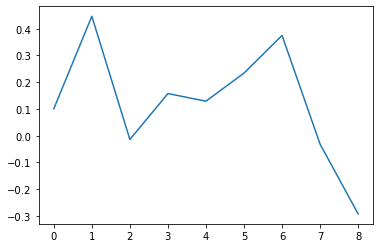

In [6]:
plt.plot(act_40_lh_mean-act_40_rh_mean)

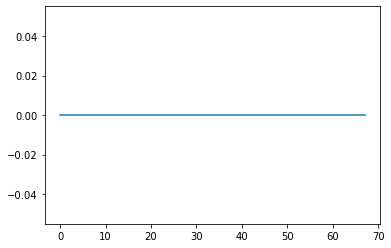

In [7]:
# print('The p-value of L/R difference is: '+str(ttest_rel(act_40_lh_mean,act_40_rh_mean,axis=0).pvalue))
pval = ttest_ind(act_40,act_rand,axis=0).pvalue
plt.plot(np.where(pval<0.05,1,0))
for i in range(68):
    if pval[i] <0.05 :
        print(label_names[i])
# fig, ax = plt.subplots()
# ax.pcolormesh(act_40_lh-act_40_rh)

In [15]:

stcs = apply_inverse_epochs(list(epochs_4F), inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=False)
stc_mean= np.mean(stcs)

TypeError: epochs must be an instance of BaseEpochs, got <class 'list'> instead

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /data/home/viscent/mne_data/MNE-sample-data/subjects/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


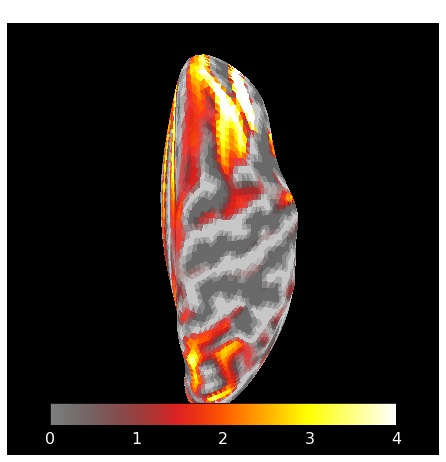

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /data/home/viscent/mne_data/MNE-sample-data/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


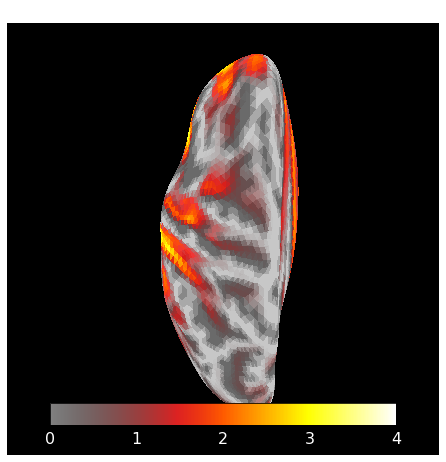

In [12]:
vertno_max, time_max = stc_mean.get_peak(hemi='rh')

subjects_dir = data_path + '/subjects'
surfer_kwargs = dict(
    hemi='rh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[0, 2, 4]),backend= 'matplotlib', views='dor',
    initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
brain = stc_mean.plot(**surfer_kwargs)
vertno_max, time_max = stc_mean.get_peak(hemi='lh')

subjects_dir = data_path + '/subjects'
surfer_kwargs = dict(
    hemi='lh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[0, 2, 4]),backend= 'matplotlib', views='dor',
    initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
brain = stc_mean.plot(**surfer_kwargs)



Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 60 (4 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 3
Processing epoch : 2 / 3
Processing epoch : 3 / 3
[done]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /data/home/viscent/mne_data/MNE-sample-data/subjects/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


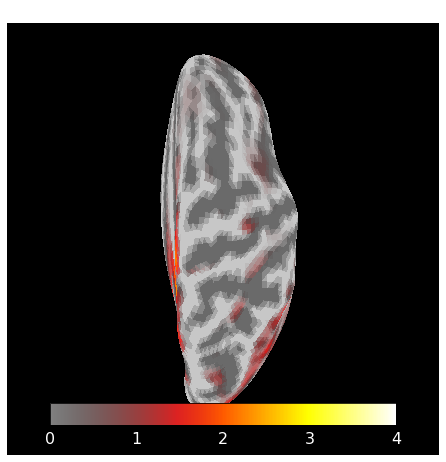

Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /data/home/viscent/mne_data/MNE-sample-data/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


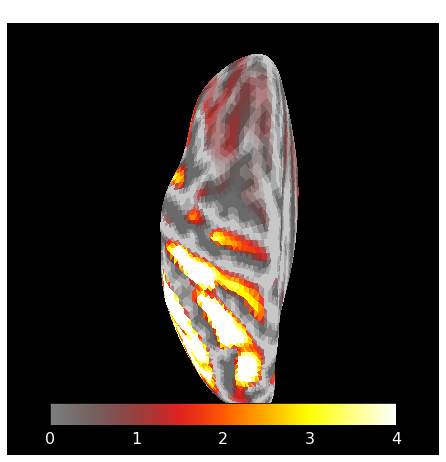

In [13]:
stcs = apply_inverse_epochs(epoch_RF, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=False)
stc_mean= np.mean(stcs)
vertno_max, time_max = stc_mean.get_peak(hemi='rh')

subjects_dir = data_path + '/subjects'
surfer_kwargs = dict(
    hemi='rh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[0, 2, 4]),backend= 'matplotlib', views='dor',
    initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
brain = stc_mean.plot(**surfer_kwargs)
vertno_max, time_max = stc_mean.get_peak(hemi='lh')

subjects_dir = data_path + '/subjects'
surfer_kwargs = dict(
    hemi='lh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[0, 2, 4]),backend= 'matplotlib', views='dor',
    initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
brain = stc_mean.plot(**surfer_kwargs)


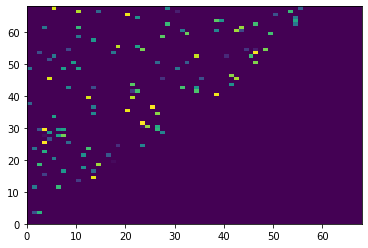

In [8]:
pval = 1-ttest_rel(cons_40,cons_rand,axis=0).pvalue
pval_mat=np.where(pval>0.95,pval-0.95,0)
fig, ax = plt.subplots()
ax.pcolormesh(pval_mat)

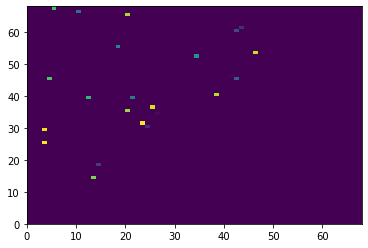

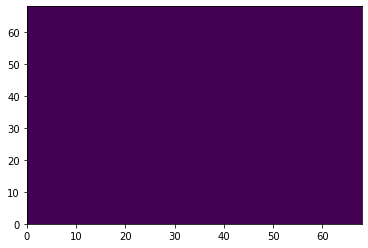

In [9]:
pval = 1-ttest_rel(cons_40,cons_rand,axis=0).pvalue
fig, ax = plt.subplots()
pmin = 0.99
ax.pcolormesh(np.where(pval>pmin,pval-pmin,0))
fig, ax = plt.subplots()
ax.pcolormesh(np.where(pval>0.999,pval-pmin,0))

In [10]:
result_dir = op.join(dataRoot, 'results','overall')
if not op.exists(result_dir):
    os.makedirs(result_dir)
# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)
# node_order = node_order[:69]

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
fig,ax=plot_connectivity_circle(cons_40.mean(axis=0), label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors, 
                         title='All-to-All Connectivity 40 Hz '
                               'Condition (PLI)')
fig.savefig(op.join(result_dir,'40-connectivity.png'),facecolor='black')
fig,ax=plot_connectivity_circle(cons_rand.mean(axis=0), label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors, 
                         title='All-to-All Connectivity Random '
                               'Condition (PLI)')
fig.savefig(op.join(result_dir,'rand-connectivity.png'),facecolor='black')
dcon_res = cons_40.mean(axis=0) - cons_rand.mean(axis=0)
fig,ax=plot_connectivity_circle(np.where(dcon_res<0,0,dcon_res), label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors, colormap='hot', 
                         title='All-to-All Connectivity Upregulated '
                               '(PLI)')
fig.savefig(op.join(result_dir,'up-connectivity.png'),facecolor='black')
fig,ax=plot_connectivity_circle(np.where(dcon_res>0,0,-1*dcon_res), label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors, colormap='gray',
                         title='All-to-All Connectivity Downregulated '
                               '(PLI)')
fig.savefig(op.join(result_dir,'down-connectivity.png'),facecolor='black')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/data/home/viscent/.conda/envs/mne/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-14b9488aacd3>", line 33, in <module>
    fig,ax=plot_connectivity_circle(cons_40.mean(axis=0), label_names, n_lines=300,
  File "/data/home/viscent/.conda/envs/mne/lib/python3.9/site-packages/mne/viz/circle.py", line 425, in plot_connectivity_circle
    plt_show(show)
  File "/data/home/viscent/.conda/envs/mne/lib/python3.9/site-packages/mne/viz/utils.py", line 108, in plt_show
    (fig or plt).show(**kwargs)
  File "/data/home/viscent/.conda/envs/mne/lib/python3.9/site-packages/matplotlib/pyplot.py", line 378, in show
    return _backend_mod.show(*args, **kwargs)
  File "/data/home/viscent/.conda/envs/mne/lib/python3.9/site-packages/ipykerne

TypeError: object of type 'NoneType' has no len()

In [ ]:
pval = 1-ttest_rel(cons_40,cons_rand,axis=0).pvalue
pval_mat = np.where(pval>0.95,1-pval,0)
fig,ax=plot_connectivity_circle(pval_mat, label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors, colormap='hot', 
                         title='Robustly Altered Connectivity'
                               '(p<0.05)')
fig.savefig(op.join(result_dir,'t-test.png'),facecolor='black')

pval_mat = np.where(pval>0.99,1-pval,0)
fig,ax=plot_connectivity_circle(pval_mat, label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors, colormap='hot', 
                         title='Robustly Altered Connectivity'
                               '(p<0.01)')
fig.savefig(op.join(result_dir,'t-test.png'),facecolor='black')

pval_mat = np.where(pval>0.999,1-pval,0)
fig,ax=plot_connectivity_circle(pval_mat, label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors, colormap='hot', 
                         title='Robustly Altered Connectivity'
                               '(p<0.001)')
fig.savefig(op.join(result_dir,'t-test.png'),facecolor='black')